In [1]:
# !pip install pygwalker

In [2]:
import pygwalker as pyg

In [3]:
# 경로설정
import sys
path = "C:\github/aide-analysis/"
path2 = 'C:\github/aide-analysis/notebook/temp_ljs/Develop/지주리포트Lite/실거래 이상값 제거 연구 및 추론/모듈 및 압축파일 보관 폴더'
sys.path.append(path)
sys.path.append(path2)

import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd())))
# 한글폰트
import os
import matplotlib.pyplot as plt
if os.name =='posix':
    plt.rc('font',family = 'ApplGothic')
else:
    plt.rc('font',family = 'Malgun Gothic')
    
# 경고출력문 제거
import warnings
warnings.filterwarnings("ignore")

# 모듈 import
import pandas as pd
import src
from src.openapi import KakaoLocalAPI as kakao
from openpyxl import load_workbook
from src.utils import insert_dataframe_to_excel_sheet
from src.sql import DatabaseHandler
from src.temp import *
from datetime import datetime
import datetime
from dateutil.relativedelta import relativedelta
from src.bigquery import BigqueryHandler
import seaborn as sns
import numpy as np
import statistics
from tqdm import tqdm
import config
from core.config import Config
import json
from datetime import datetime
import geopandas as gpd
from tqdm import tqdm
import folium
from src.bigquery import bigquery_client, bigquery
import geopandas as gpd
from shapely import wkt
from openpyxl import load_workbook
from src.utils import insert_dataframe_to_excel_sheet
from openpyxl.utils.dataframe import dataframe_to_rows
from difflib import SequenceMatcher
import openpyxl
import math
from 실거래전처리 import TradeProcessing

config = Config()
BH = BigqueryHandler()


# DataFrame 디스플레이 설정
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)

# 지난달(23년01월)대비 이번달(23년02월) 매매가격이 떨어진 단지 찾기

- 타입별로 특수성이 있을 수 있기때문에 areaSixGroupNo 대신 pyeongNo를 기준으로 동 타입기준으로 가격비교 하기 -> 이렇게 했을때 문제가 없을지도 검증이 필요하다

In [4]:
# sql = f"""

# SELECT sigunguCode
# FROM `aidepartners.aide.code_sigungu`
# WHERE (isMulti = True AND guLevel = True AND siLevel = False) OR (isMulti = False AND guLevel = True AND siLevel = True)
# """
# sigunguList = BH.read_table(sql)
# sigunguList = list(sigunguList['sigunguCode'])

In [5]:
sql = f"""
SELECT distinct sidoCode
FROM `aidepartners.aide.code_sigungu`
"""
sidoList = BH.read_table(sql)
sidoList = list(sidoList['sidoCode'])

In [53]:
sql =f"""
SELECT T1.*
FROM(
    SELECT sidoCode,
           complexNo, 
           complexName, 
           address,
           areaSixGroupNo, 
           pyeongNo,
           useApproveYear, 
           totalHouseholdCount, 
           tradeType, 
           jeonyongArea,
           supplyArea,
           contractDate, 
           averagePyeong, 
           averagePrice, 
           isFloor, 
           isProcessing1, 
           isProcessing2, 
           isProcessing3, 
           interpolate, 
           yearMonth, 
           isReal, 
           finalProcessing, 
           predict,
           RANK() OVER(PARTITION BY complexNo, complexName, pyeongNo ORDER BY yearMonth DESC) AS rn -- 월 구분
    FROM `aidepartners.raw.aide_apartment_price_origin`
    WHERE -- sidoCode ='28'
          -- sidoCode ='11' 
          yearMonth >='2023-01-01' 
          AND isReal = True
    ORDER BY complexNo, areaSixGRoupNo
    ) AS T1
"""
dataframe = BH.read_table(sql)

# 전달대비 하락한 지역 추론을 위한 데이터프레임 copy 및 전처리
data = dataframe.copy()
dropIdx = data[data['sidoCode'].isna()].index
data = data.drop(index = dropIdx)

In [54]:
# 거래가 두달 연속 있는 단지중 전달대비 하락한 단지
def findFallPrice(data):
    result = pd.DataFrame()
    for sido in sidoList:
        df = data[data['sidoCode']==sido].reset_index(drop = True)
        df_result = pd.DataFrame()
        df_pecent = pd.DataFrame({'per':[]})
        df_unique  = df[['complexNo','pyeongNo','jeonyongArea', 'supplyArea']].drop_duplicates().reset_index(drop =True)
        for i in range(0, len(df_unique)):
            cNo =df_unique['complexNo'].iloc[i]
            typeOption = df_unique['pyeongNo'].iloc[i]
            # 거래가 두달이상 연속으로 있는경우
            if len(df.loc[(df['complexNo']==cNo)&(df['pyeongNo']==typeOption), 'rn'].unique()) >1:
                # 최근거래과 과거거래 금액 차이 비교
                recentPrice = df.loc[(df['complexNo']==cNo)&(df['pyeongNo']==typeOption)&(df['rn']==1),'averagePyeong'].mean()
                pastPrice = df.loc[(df['complexNo']==cNo)&(df['pyeongNo']==typeOption)&(df['rn']==2),'averagePyeong'].mean()
                price = pastPrice - recentPrice
                per = recentPrice / pastPrice # 전달대비 현재 실거래 비율
                if (price >0)&(per<=0.85) : # 전달 거래보다 싸게거래된 경우
                    df_result = df_result.append(df[(df['complexNo']==cNo)&(df['pyeongNo']==typeOption)])
                    if i ==0:
                        df_result['per'] = ''
                    df_result.loc[(df_result['complexNo']==cNo)&(df_result['pyeongNo']==typeOption),'per'] = per

                    # 결과테이블 세팅
                    df_result = df_result[['complexNo','complexName','address','pyeongNo','jeonyongArea', 'supplyArea','per']].drop_duplicates(subset = ['complexNo','pyeongNo']).sort_values(by = 'per')
                    df_result['per'] =  round(df_result['per'], 2)

                    # 컬럼정리
                    df_report = df_result.rename(columns = {'complexName':'단지명',
                                                            'pyeongNo':'면적타입',
                                                            'address':'주소',
                                                            'jeonyongArea':'전용면적',
                                                            'supplyArea':'공급면적',
                                                            'per':'전달 대비 실거래 가격'}).reset_index(drop = True)
                    result = result.append(df_report)
    result = result.reset_index(drop = True).sort_values(by = '전달 대비 실거래 가격')
    result = result.drop_duplicates(subset = ['단지명','면적타입']).reset_index(drop = True)
    return result

In [64]:
result = findFallPrice(data)
result

,complexNo,단지명,주소,면적타입,전용면적,공급면적,전달 대비 실거래 가격
0,106798,이화(816),경상북도 구미시 인의동,1,44.32,62.09,0.70
1,112392,서동탄역파크자이,경기도 화성시 능동,2,84.97,110.33,0.70
2,4309,한신,경상북도 김천시 황금동,2,84.97,103.04,0.70
3,7114,삼도한솔타운3차,경상북도 포항시 남구 연일읍,3,84.81,98.94,0.72
4,108218,세중세미클래식,충청남도 논산시 취암동,1,36.29,53.30,0.72
5,25977,청주개신주공1단지,충청북도 청주시 서원구 개신동,2,59.90,85.57,0.72
6,25051,주공2단지,대전시 중구 문화동,1,49.77,71.65,0.74
7,111583,세종모닝시티2차(도시형),세종시 세종시 나성동,1,23.28,36.34,0.74
8,19548,금부마을호반리젠시빌3차,광주시 서구 금호동,1,84.75,109.19,0.76
9,110060,북실,강원도 정선군 정선읍,1,39.30,45.15,0.76


In [61]:
df_info = result[['complexNo','면적타입']].rename(columns = {'면적타입':'pyeongNo'})
sql =f"""
SELECT T1.*
FROM(
    SELECT sidoCode,
           complexNo, 
           complexName, 
           address,
           areaSixGroupNo, 
           pyeongNo,
           useApproveYear, 
           totalHouseholdCount, 
           tradeType, 
           jeonyongArea,
           supplyArea,
           contractDate, 
           averagePyeong, 
           averagePrice, 
           isFloor, 
           isProcessing1, 
           isProcessing2, 
           isProcessing3, 
           interpolate, 
           yearMonth, 
           isReal, 
           finalProcessing, 
           predict
    FROM `aidepartners.raw.aide_apartment_price_origin`
    WHERE yearMonth >='2021-01-01' 
          AND isReal = True
          AND complexNo in {tuple(df_info['complexNo'].unique())}
    ORDER BY complexNo, areaSixGRoupNo
df_info = result[['complexNo','면적타입']].rename(columns = {'면적타입':'pyeongNo'})    ) AS T1
"""
df_new = BH.read_table(sql)

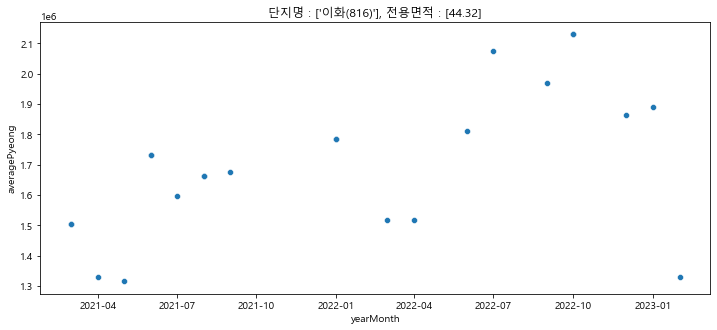

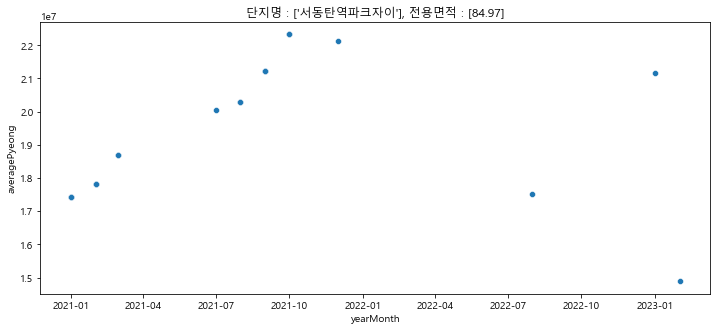

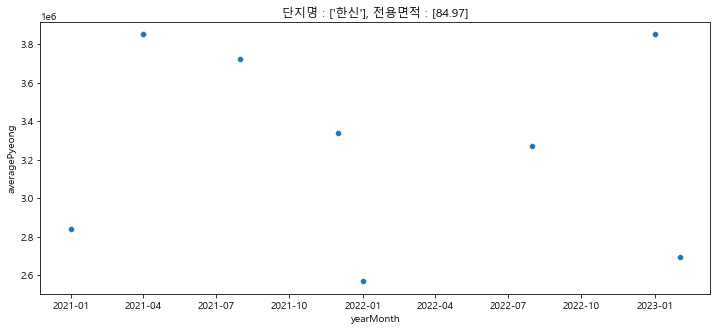

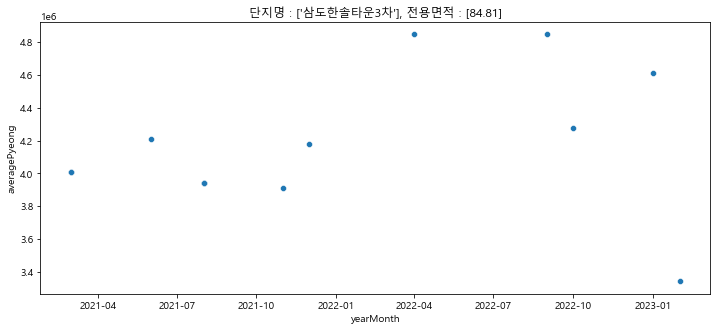

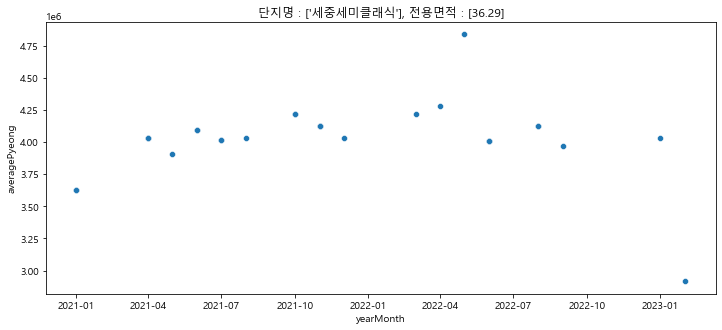

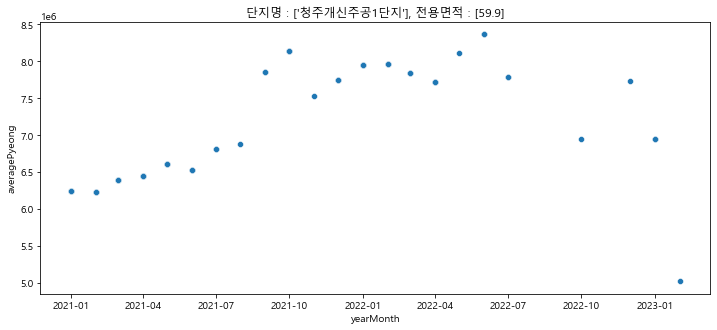

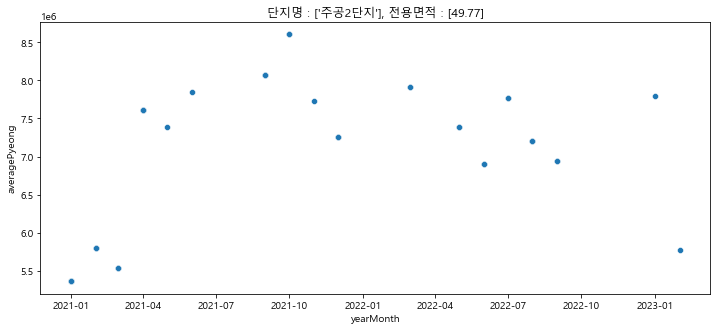

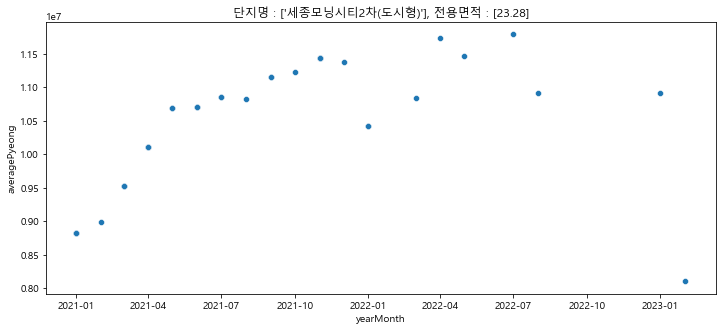

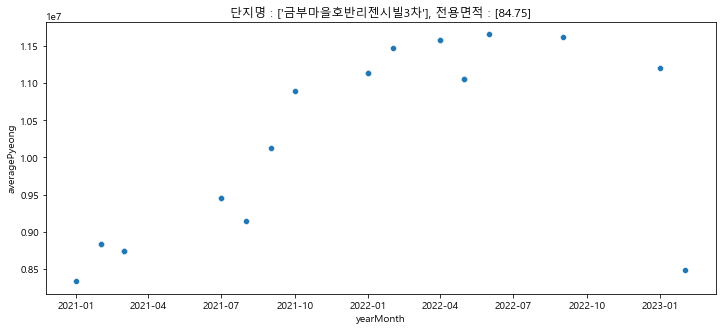

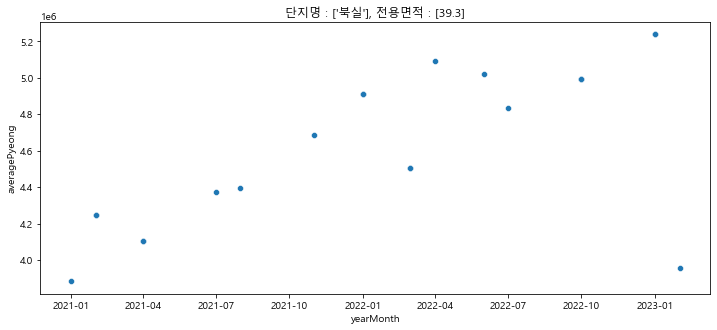

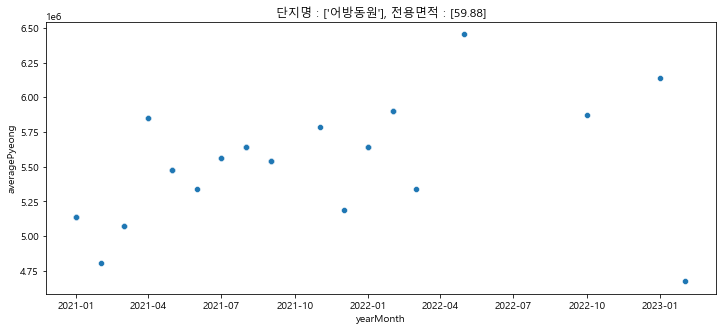

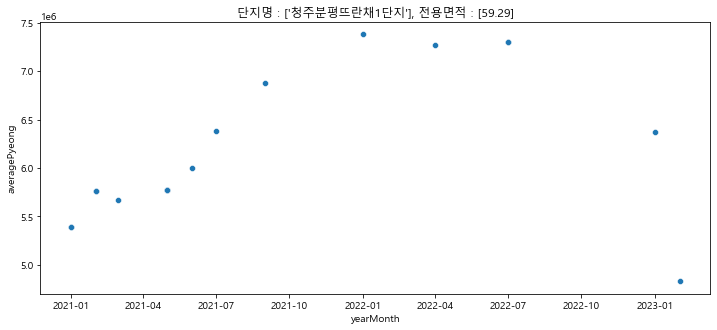

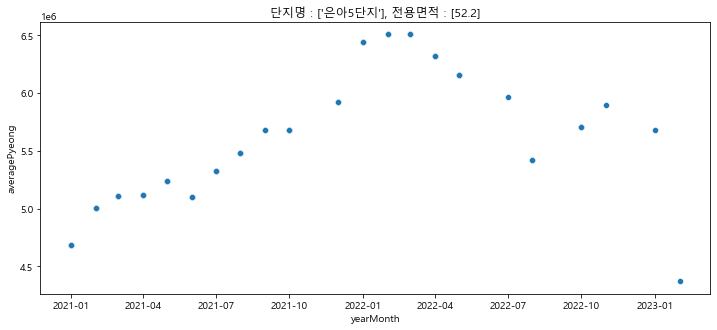

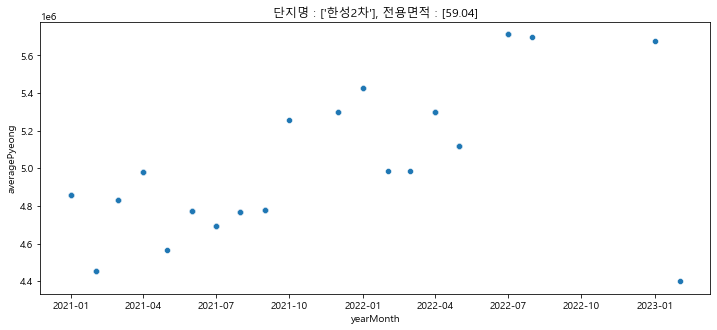

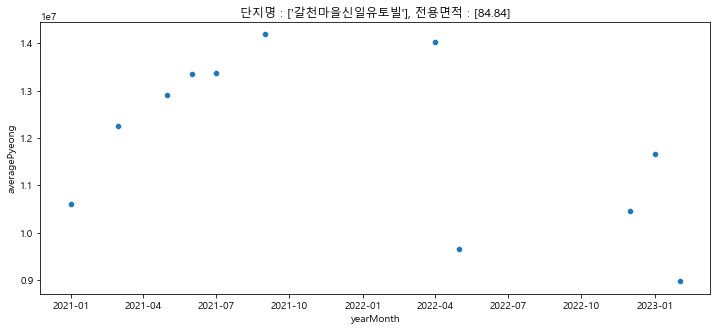

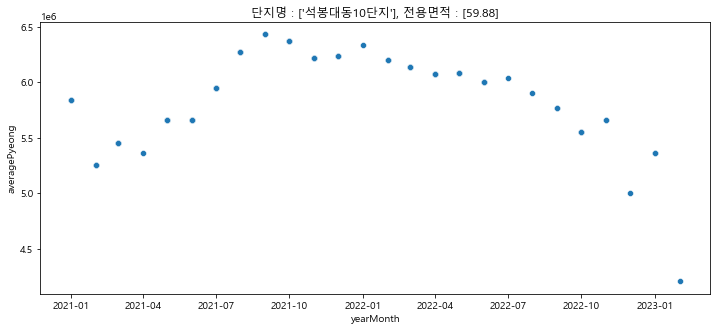

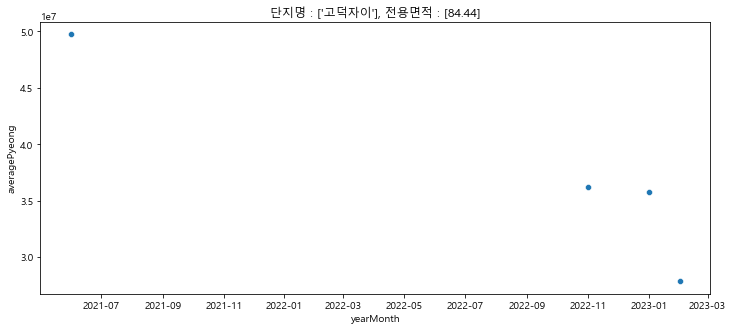

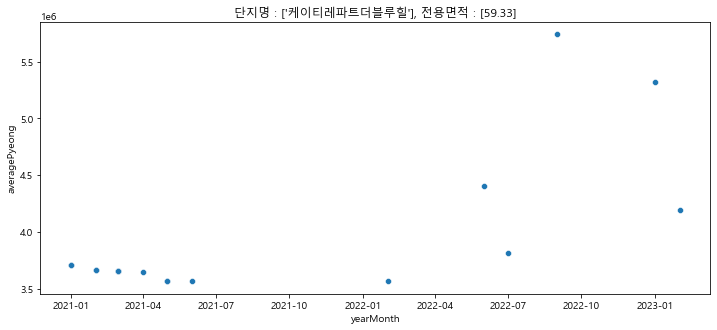

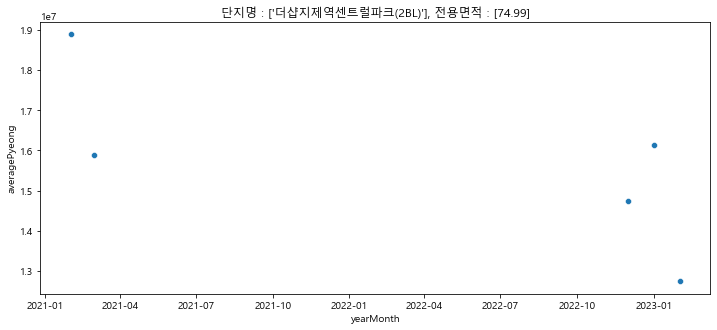

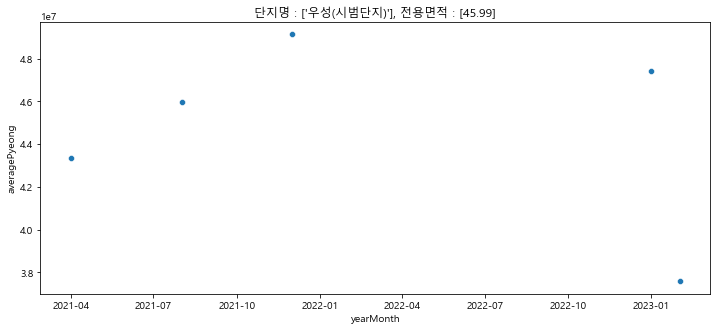

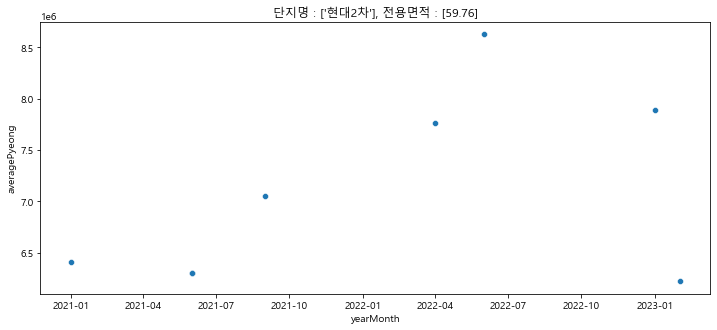

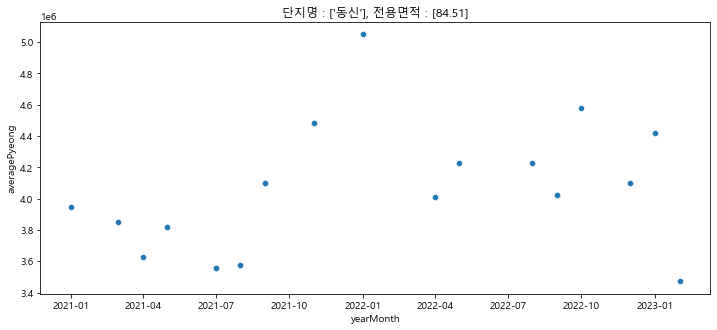

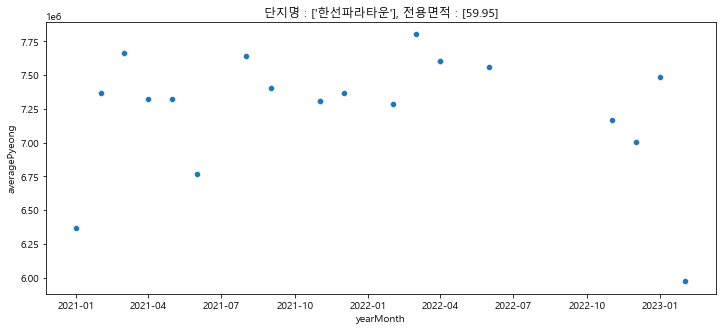

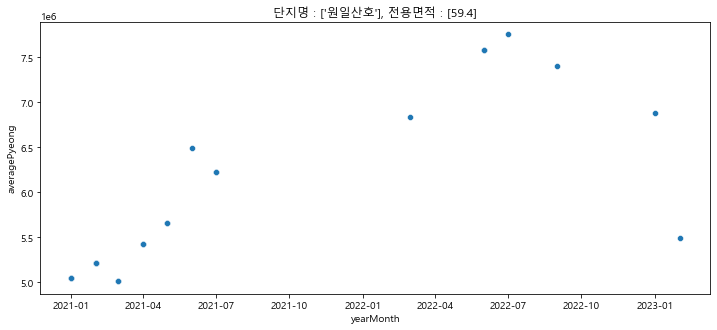

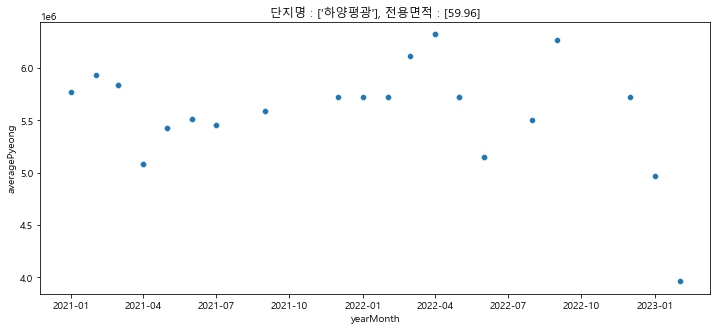

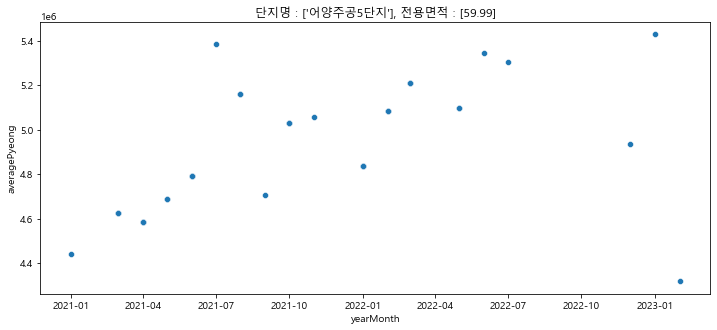

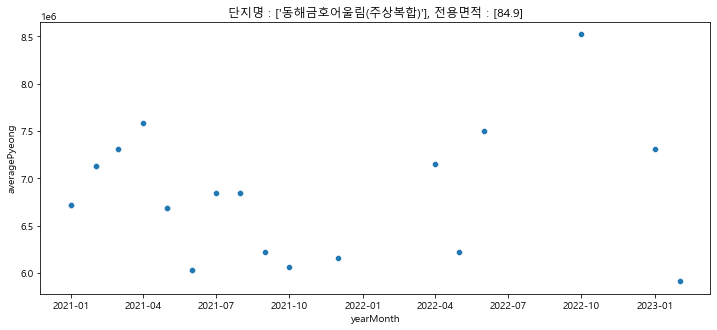

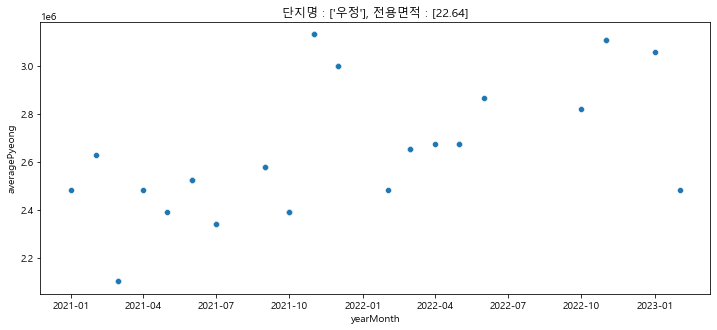

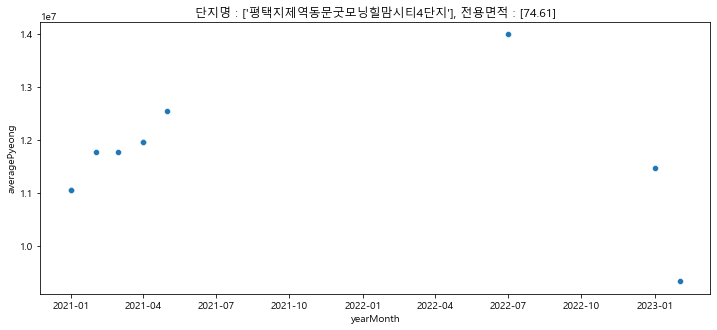

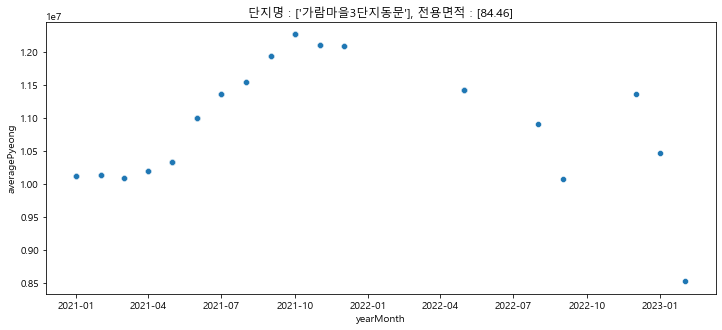

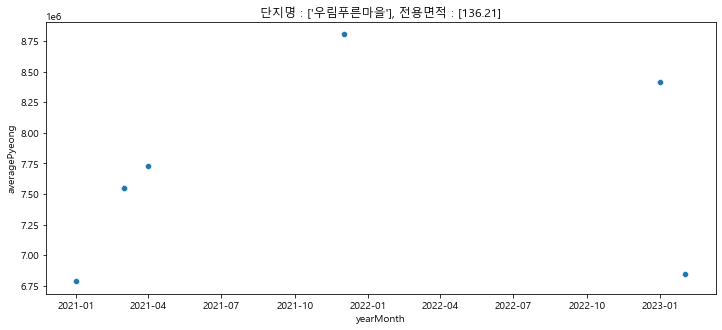

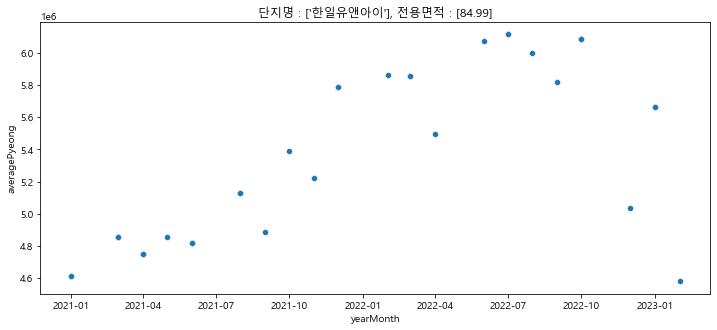

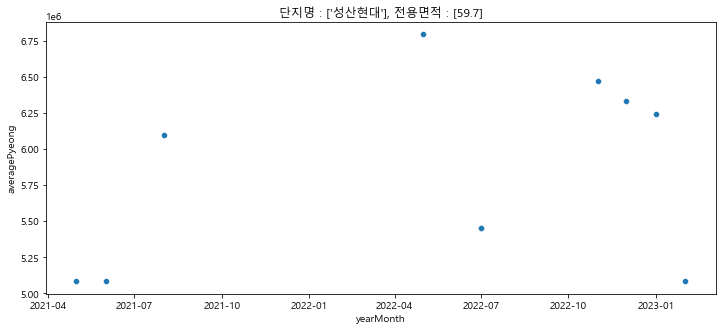

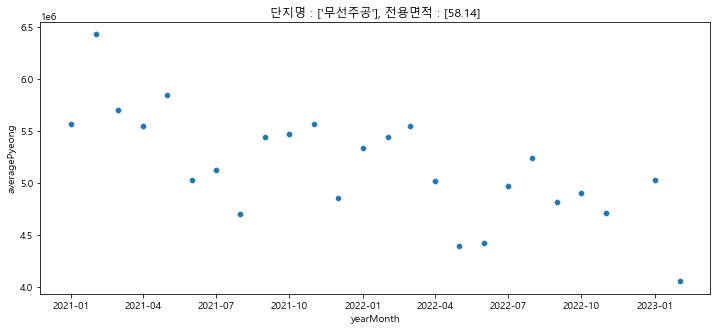

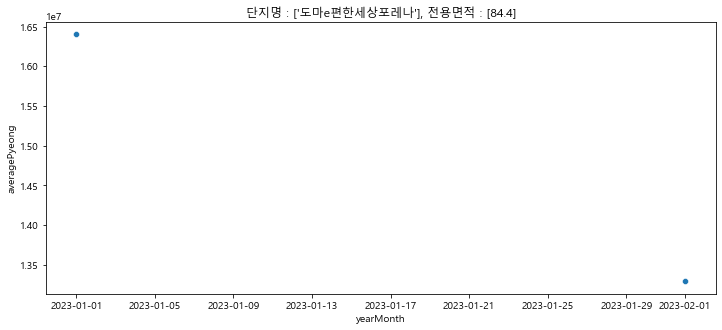

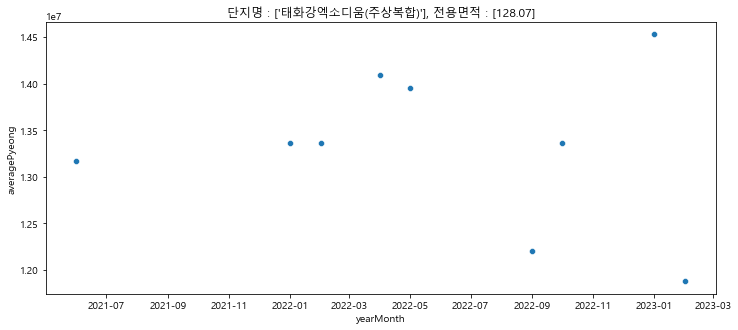

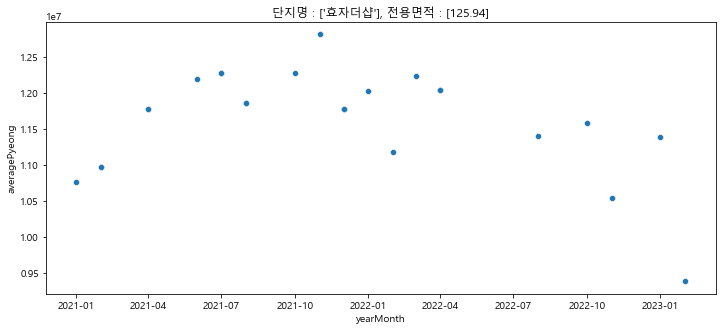

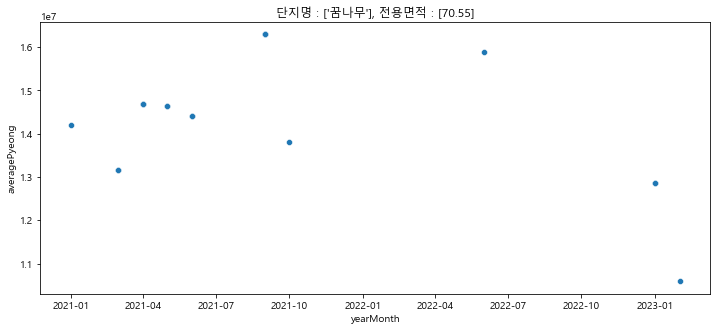

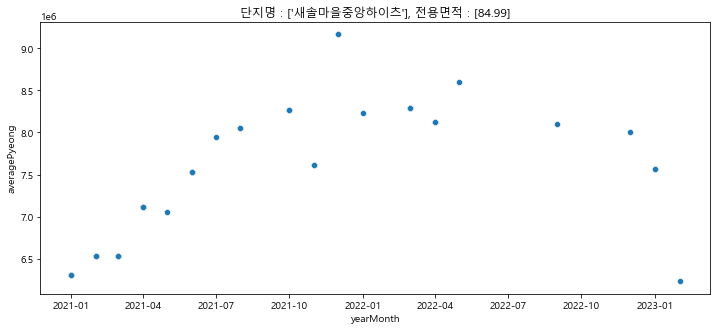

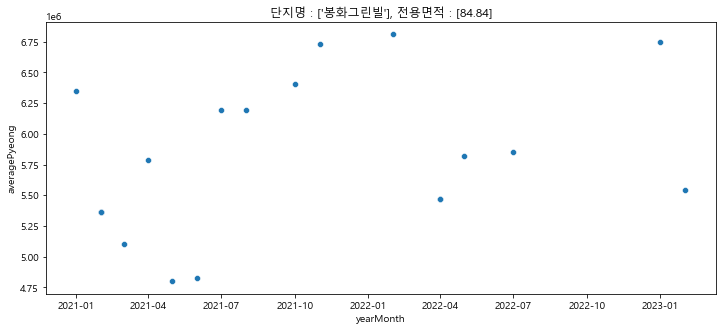

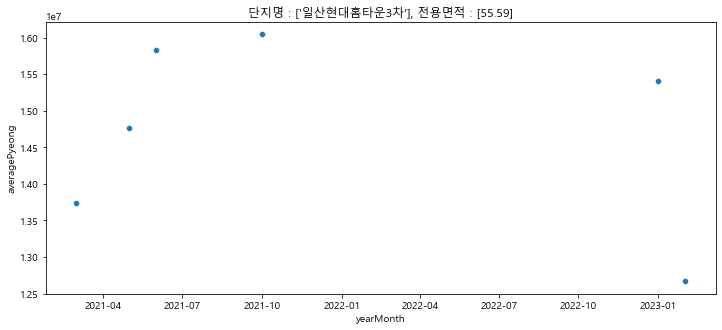

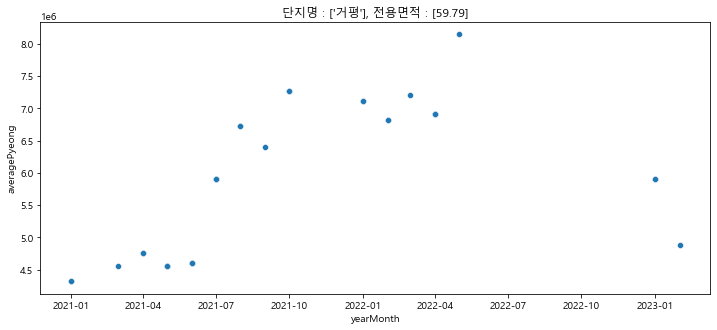

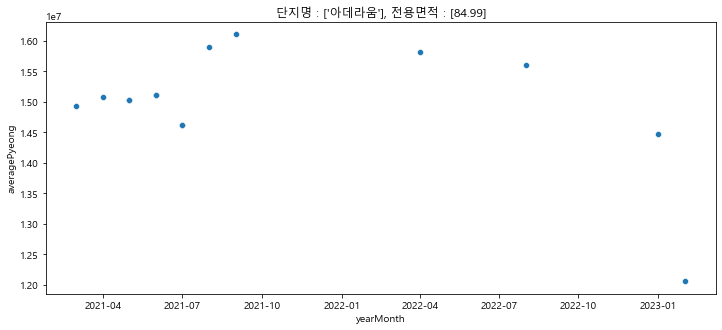

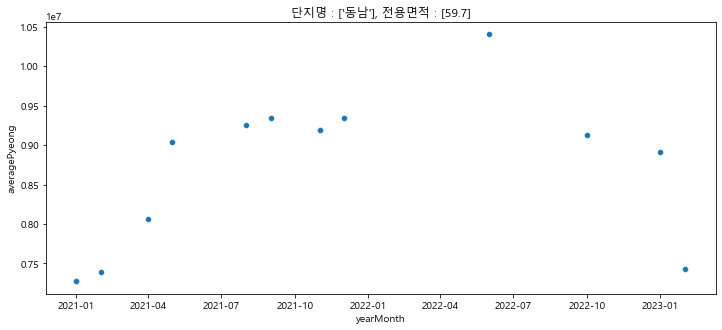

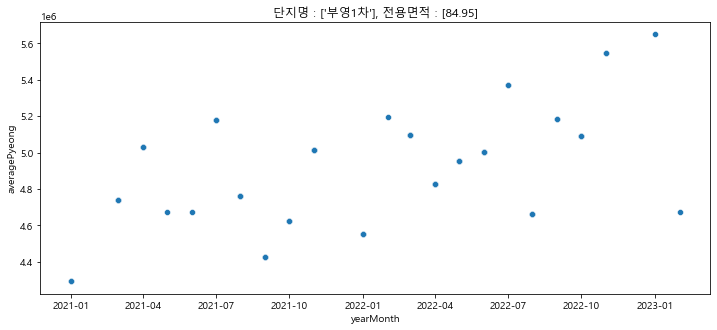

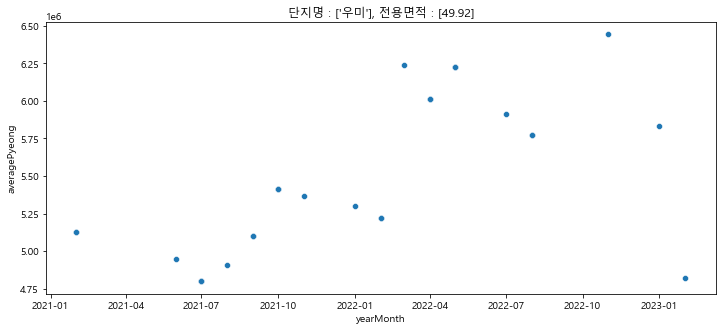

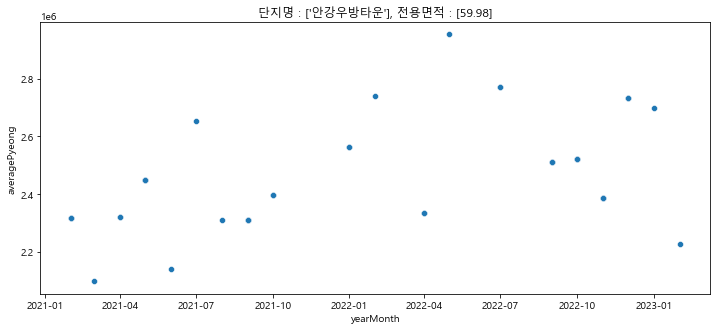

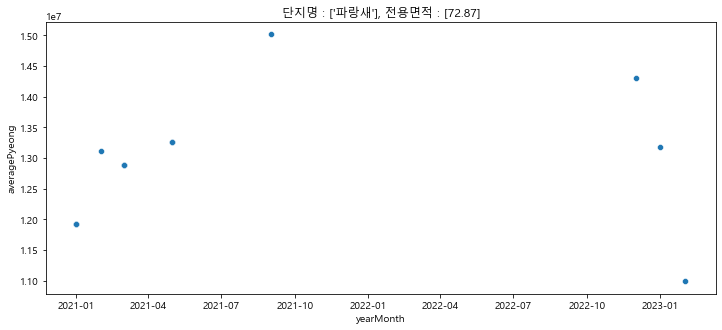

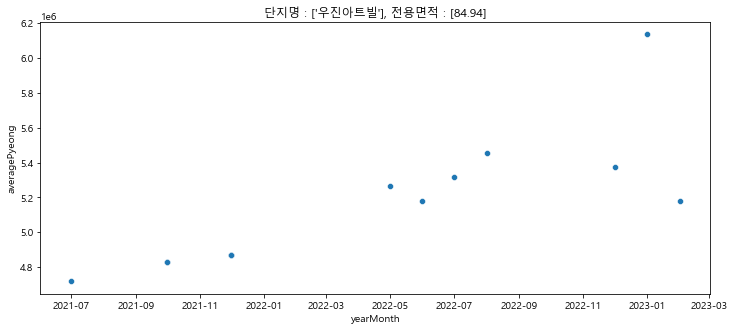

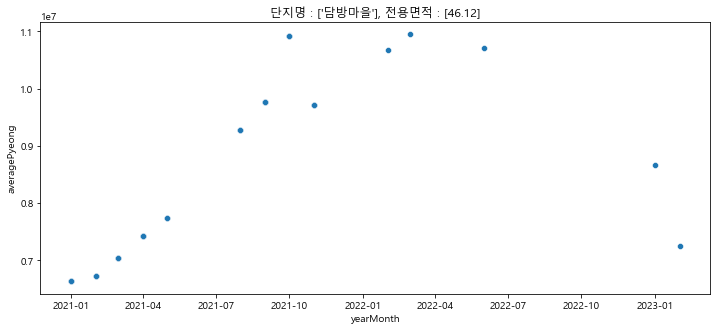

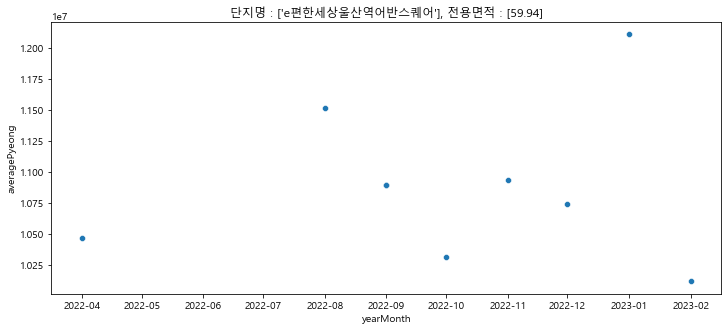

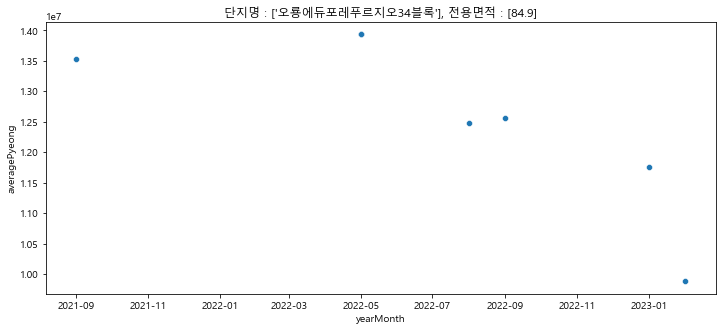

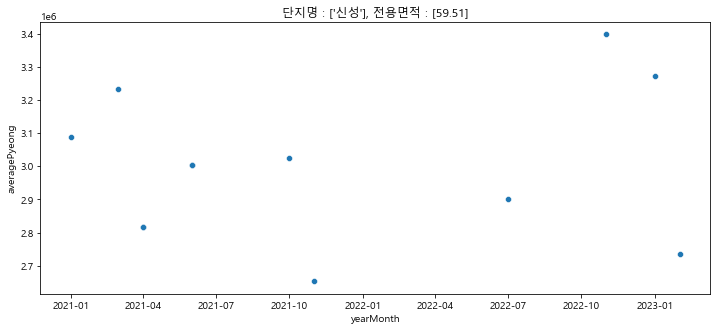

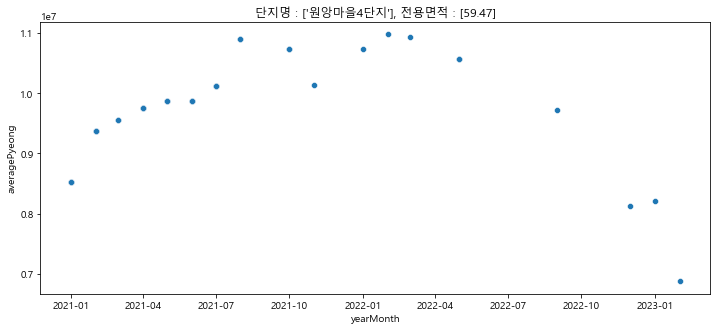

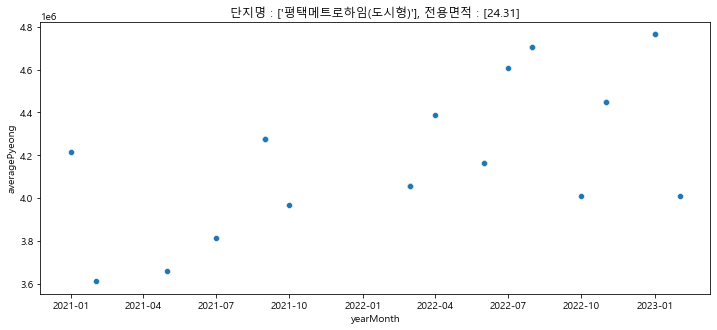

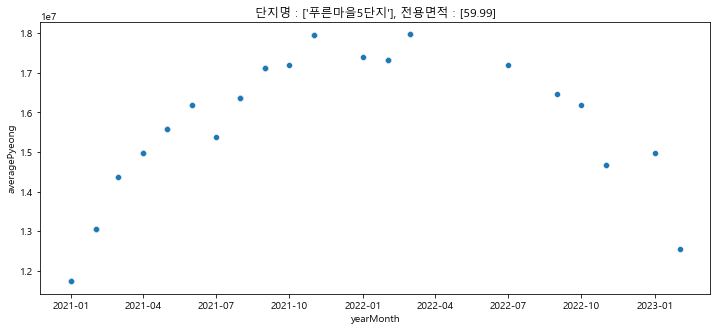

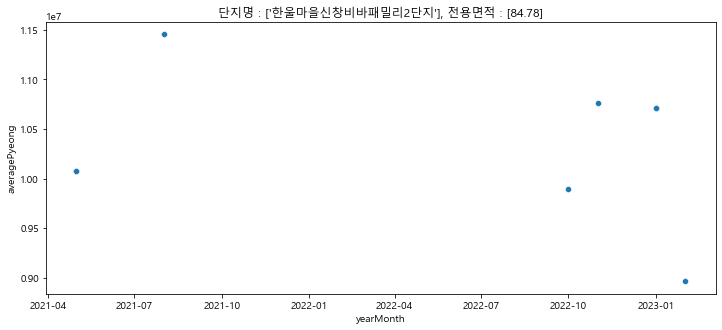

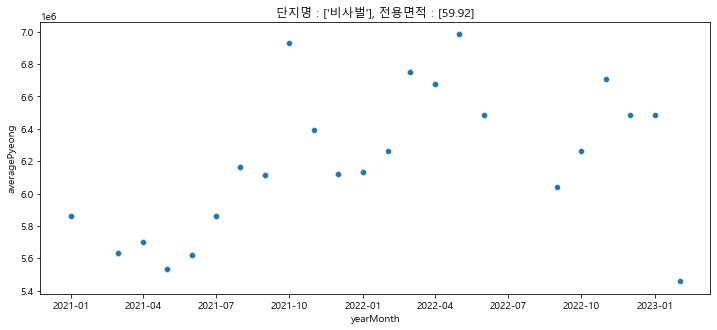

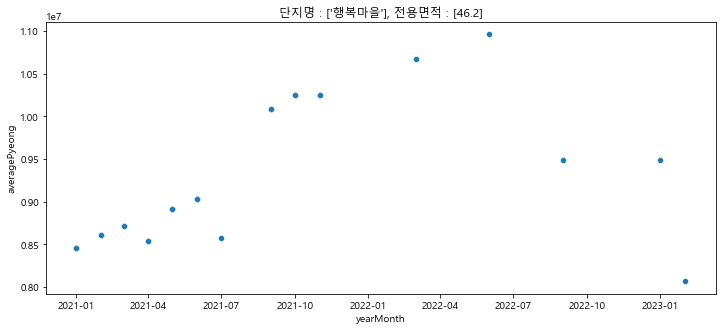

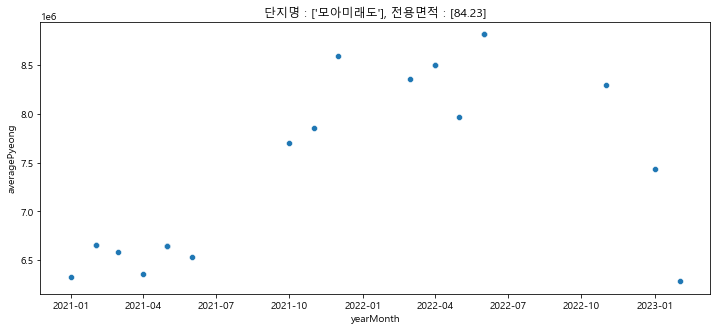

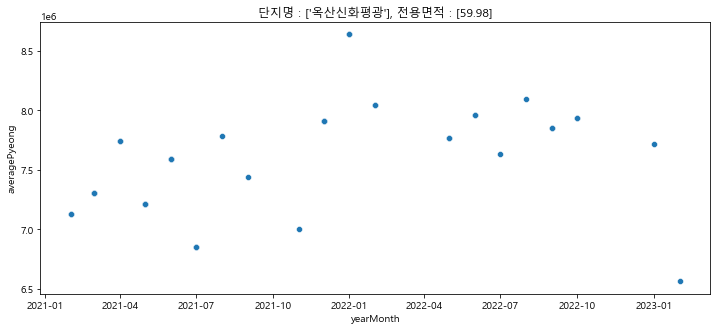

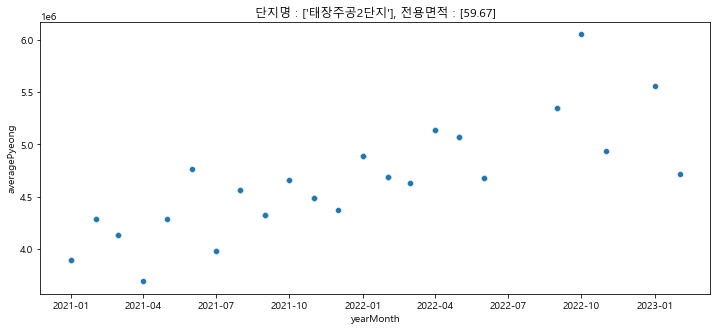

In [63]:
# 최근하락한 단지의 최근2년 실거래 변동 확인
for i in range(0, len(df_info)):
    
    cNo = df_info['complexNo'].iloc[i]
    pyeong = df_info['pyeongNo'].iloc[i]
    
    # 단지-타입 특정 
    df_unique = df_new[(df_new['complexNo']==cNo)&(df_new['pyeongNo']==pyeong)]
    
    # 차트 제목에 사용할 파라미터 저장
    danjiName = df_unique['complexName'].unique()
    jeonyong = df_unique['jeonyongArea'].unique()
    
    # 시각화
    ## 실제값 필터
    df_real = df_unique[df_unique['isReal']==True].reset_index(drop = True)
    plt.figure(figsize = (12, 5))
    sns.scatterplot(df_real['yearMonth'], df_real['averagePyeong'])
    plt.title(f"단지명 : {danjiName}, 전용면적 : {jeonyong}")
    plt.show()

# 전세가율

In [110]:
sql = f"""
SELECT CASE WHEN provider = 'kab' THEN max(baseYearMonthDay) END AS kab,
       CASE WHEN provider = 'kbstar' THEN max(baseYearMonthDay) END AS kbstar,
       CASE WHEN provider = 'neonet' THEN max(baseYearMonthDay) END AS neonet
        
FROM `aidepartners.aide.complex_market_price`
GROUP BY provider
"""
time = BH.read_table(sql)
time

,kab,kbstar,neonet
0,NaT,NaT,2023-02-22
1,NaT,2023-02-24,NaT
2,2023-02-20,NaT,NaT


In [115]:
day1 = time['kab'].dropna().iloc[0]
day2 = time['kbstar'].dropna().iloc[0]
day3 = time['neonet'].dropna().iloc[0]

In [71]:
day = time.iloc[0][0]

In [128]:
sql = f"""
SELECT danji.sidoCode,
       danji.sigunguCode,
       market.complexNo,
       danji.complexName,
       danji.sigunguName,
       detailAddress,
       market.areaNo,
       area.jeonyongArea,
       area.supplyArea,
       market.dealAveragePrice,
       market.leaseAveragePrice,
       market.leaseAveragePrice/market.dealAveragePrice AS ratio
FROM `aidepartners.aide.complex_market_price` AS market
LEFT JOIN (SELECT sidoCode,sigunguCode, complexNo, complexName, sigunguName, detailAddress FROM `aidepartners.aide.complex_danji_information`) AS danji ON market.complexNo = danji.complexNo
LEFT JOIN (SELECT complexNo, pyeongNo, jeonyongArea, supplyArea FROM `aidepartners.aide.complex_area_information_prod`) AS area ON market.complexNo =area.complexNo AND market.areaNo = area.pyeongNo
WHERE market.baseYearMonthDay = "{day}"
"""
df_ratio = BH.read_table(sql)

In [136]:
df_ratio[(df_ratio['sidoCode']=='11')&(-df_ratio['complexName'].str.contains('도시형'))&(-df_ratio['complexName'].str.contains('주상복합'))].sort_values(by = 'ratio',ascending = False).head(200)[['complexName','sigunguName','jeonyongArea','supplyArea','ratio']].reset_index(drop = True)

,complexName,sigunguName,jeonyongArea,supplyArea,ratio
0,대림문영칸타빌레,서울시 영등포구,84.89,102.05,0.819672
1,서소문,서울시 서대문구,39.67,39.67,0.800000
2,서소문,서울시 서대문구,42.64,42.64,0.800000
3,서소문,서울시 서대문구,40.66,40.66,0.800000
4,서소문,서울시 서대문구,39.34,39.34,0.800000
5,신월방원(방원예뜨랑),서울시 양천구,84.96,106.98,0.785714
6,신월방원(방원예뜨랑),서울시 양천구,84.94,105.84,0.785714
7,신월방원(방원예뜨랑),서울시 양천구,84.86,105.95,0.785714
8,동인,서울시 구로구,78.64,104.01,0.784091
9,동인,서울시 구로구,71.38,94.41,0.773810
